<a href="https://colab.research.google.com/github/reban87/HuggingFace/blob/main/USING%20%F0%9F%A4%97%20TRANSFORMERS/Behind%20the%20Pipeline/USING_TRANSFORMERS(Behind_Pipeline).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# UNCOMMENT FOR INSTALLATION

#!pip install transformers

In [4]:
from transformers import pipeline                       # IMPORT PIPELINE

In [6]:
classifier = pipeline("sentiment-analysis")             # INITIALIZATION OF "SENTIMENT-ANALYSIS PIPELINE"


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [7]:
classifier(["I have been waiting for hugging face course for whole life"],
           ["I hate this much"])

Ignoring args : (['I hate this much'],)


[{'label': 'POSITIVE', 'score': 0.9956978559494019}]

**`Pipeline`** groups together 3 steps: preprocessing, passing the inputs and post processing
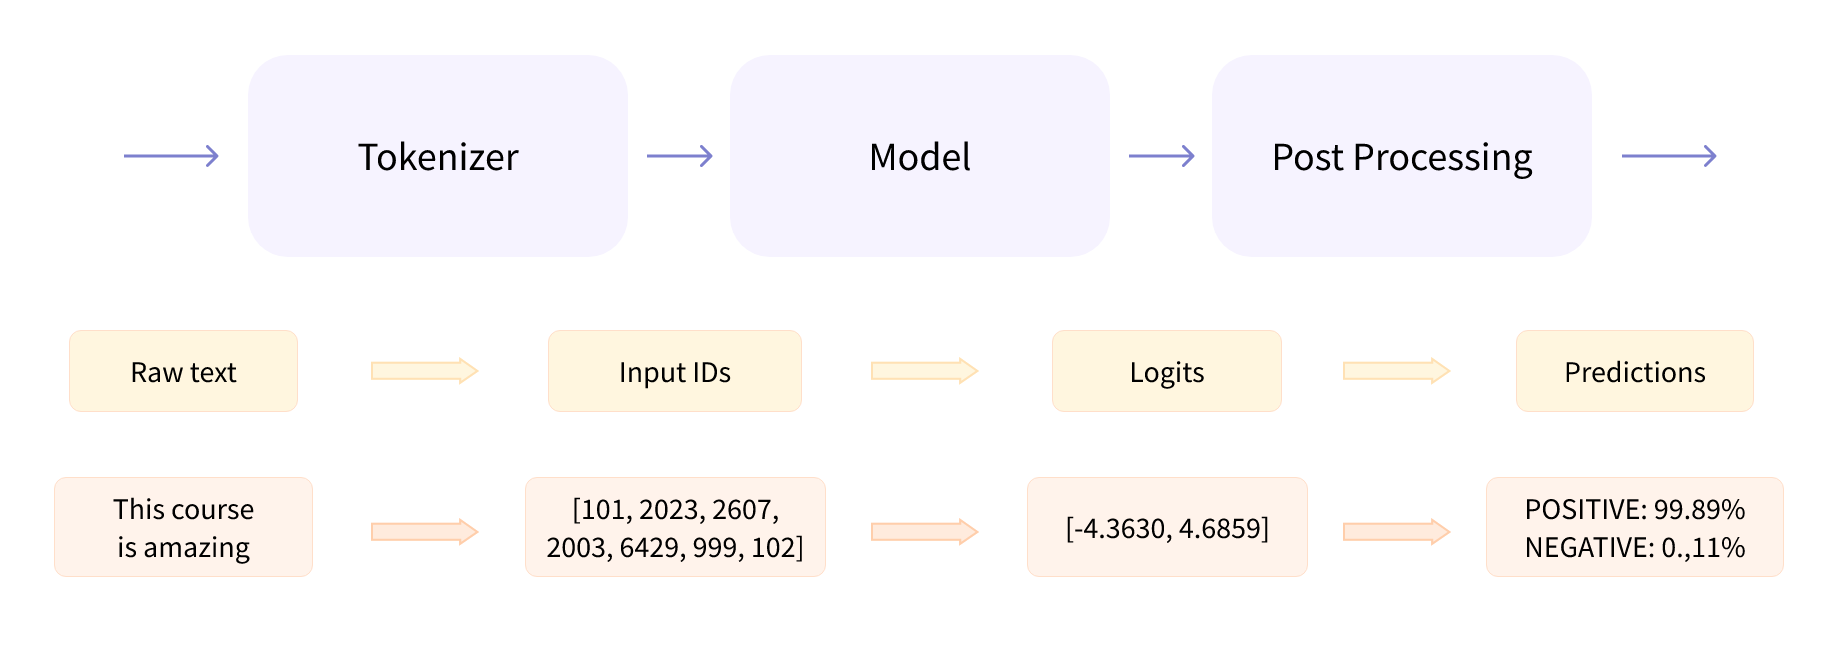

### **Preprocessing with a Tokenizer**

Like other neural networks, Transformer models can’t process raw text directly, so the first step of our pipeline is to convert the text inputs into numbers that the model can make sense of. To do this we use a tokenizer, which will be responsible for:

- Splitting the input into words, subwords, or symbols (like punctuation) that are called tokens
- Mapping each token to an integer
- Adding additional inputs that may be useful to the model

In [9]:
# USE AUTO-TOKENIZER CLASS AND ITS PRE-TRAINED METHOD FOR TOKENIZATION
from transformers import AutoTokenizer
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"              # DEFAULT CHECKPOINT OF THE SENTIMENT -ANALYSIS PIPELINE
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Once we have the tokenizer, we can directly pass our sentences to it and we’ll get back a dictionary that’s ready to feed to our model! The only thing left to do is to convert the list of **input IDs to tensors.**

In [11]:
raw_inputs = ["I've been waiting for hugging face course for long time",
              "I hate this so much"]

inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
inputs

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005, 17662,  2227,  2607,
          2005,  2146,  2051,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   102,     0,     0,     0,
             0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])}

In [14]:
# GOING THROUGH THE MODEL NOW
from transformers import AutoModel
model = AutoModel.from_pretrained(checkpoint)                # MODEL HAS BEEN INITIALIZED ABOVE

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### **High Dimensional Vector**
The vector output by the Transformer module is usually large. It generally has three dimensions:

- **Batch size:** The number of sequences processed at a time (2 in our example).
- **Sequence length:** The length of the numerical representation of the sequence (16 in our example).
- **Hidden size:** The vector dimension of each model input.


For our example, we will need a model with a sequence classification head (to be able to classify the sentences as positive or negative). So, we won’t actually use the AutoModel class, but **AutoModelForSequenceClassification:**

In [16]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
outputs

SequenceClassifierOutput([('logits', tensor([[-1.9854,  2.0398],
                                   [ 4.2141, -3.4158]], grad_fn=<AddmmBackward0>))])

In [17]:
print(outputs.logits)

tensor([[-1.9854,  2.0398],
        [ 4.2141, -3.4158]], grad_fn=<AddmmBackward0>)


Our model predicted [-1.5607, 1.6123] for the first sentence and [ 4.1692, -3.3464] for the second one.
Those are not probabilities but logits, the raw, unnormalized scores outputted by the last layer of the model. To be converted to probabilities, they need to go through a SoftMax layer (all 🤗 Transformers models output the logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, with the actual loss function, such as cross entropy):

In [18]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[1.7546e-02, 9.8245e-01],
        [9.9951e-01, 4.8549e-04]], grad_fn=<SoftmaxBackward0>)


Now we can see that the model predicted [0.0402, 0.9598] for the first sentence and [0.9995, 0.0005] for the second one. These are recognizable probability scores.

To get the labels corresponding to each position, we can inspect the id2label attribute of the model config (more on this in the next section):

In [19]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

Now we can conclude that the model predicted the following:

- First sentence: NEGATIVE: 0.0402, POSITIVE: 0.9598
- Second sentence: NEGATIVE: 0.9995, POSITIVE: 0.0005